In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv('clean_panel.csv')
df = df.drop(columns=["Unnamed: 0"])

colunas_numericas = df.columns.difference(['NOME', 'DATA'])  # Exclui 'Nome' e 'Data'

# Passo 2: Remova vírgulas e converta colunas numéricas para float
for col in colunas_numericas:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)
df

,DATA,NOME,AT,AT_CIR,CAIXA_EQ,ANC,RLP,IMOB,INVEST,PA_CIR,...,g_FCFF,g_FCFE,ROE,CI,ROIC,b_PL,b_NOPAT,LC,GIRO_AT,LEV
0,2021-06-30,3tentos,3731347.0,3079581.0,161896.0,651766.0,142487.0,508728.0,0.0,2616403.0,...,-1.030709,3.917398,0.151821,1814034.0,0.072090,1.191186,0.924604,1.177029,0.323042,1.116602
1,2021-09-30,3tentos,4353136.0,3555877.0,560333.0,797259.0,155027.0,641725.0,0.0,2044177.0,...,-110.554090,51.078403,0.114270,2967065.0,0.059997,12.618002,10.425570,1.739515,0.397310,0.436702
2,2021-12-31,3tentos,4395601.0,3354305.0,351590.0,1041296.0,247709.0,793132.0,0.0,1831275.0,...,-1.102718,-1.060091,0.080891,3035940.0,0.028437,0.590724,-0.248865,1.831677,0.371990,0.357609
3,2022-03-31,3tentos,5016524.0,3833602.0,720271.0,1182922.0,267428.0,915085.0,0.0,1984736.0,...,-5.266851,-0.553721,0.025392,3586375.0,0.027517,0.462629,6.381934,1.931542,0.253808,0.556955
4,2022-12-31,3tentos,6081989.0,4257219.0,724314.0,1824770.0,300853.0,1523576.0,0.0,2739186.0,...,-0.816910,-5.382520,0.086387,3914625.0,0.053226,1.262118,0.779274,1.554191,0.354553,0.388877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16400,2023-12-31,Zamp S.A.,4117466.0,902077.0,81279.0,3215389.0,282477.0,1378694.0,0.0,1306667.0,...,0.317866,-2.386875,0.044546,2510494.0,0.025644,0.263842,-0.704737,0.690365,0.260852,0.801342
16401,2024-03-31,Zamp S.A.,4590902.0,1430381.0,73419.0,3160521.0,279982.0,1378986.0,0.0,1247815.0,...,-6.328411,-2.750704,-0.065129,3101819.0,-0.004792,0.157851,-47.098701,1.146308,0.224057,1.367004
16402,2024-06-30,Zamp S.A.,4331322.0,1194092.0,31843.0,3137230.0,292544.0,1352974.0,0.0,1162528.0,...,-1.582437,-0.658599,-0.020988,2820296.0,0.009485,0.051122,-10.455922,1.027151,0.255868,1.254597
16403,2024-09-30,Zamp S.A.,4654390.0,1456330.0,21208.0,3198060.0,350361.0,1384537.0,0.0,1130529.0,...,-1.710967,15.539065,-0.025959,3164776.0,0.006034,-12.292067,15.080588,1.288185,0.241225,0.926930


In [22]:
from sklearn.preprocessing import MinMaxScaler 

features = ['FCFE', 'FCFF', 'g_FCFF', 'g_FCFE', 'lnAT', 'ROIC', 'b_NOPAT', 'GIRO_AT', 'LEV', 'LC', 'ROE', 'b_PL']

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df

,DATA,NOME,AT,AT_CIR,CAIXA_EQ,ANC,RLP,IMOB,INVEST,PA_CIR,...,g_FCFF,g_FCFE,ROE,CI,ROIC,b_PL,b_NOPAT,LC,GIRO_AT,LEV
0,2021-06-30,3tentos,3731347.0,3079581.0,161896.0,651766.0,142487.0,508728.0,0.0,2616403.0,...,0.825846,0.473233,0.439411,1814034.0,0.495206,0.234294,0.007363,0.000022,0.246551,0.000674
1,2021-09-30,3tentos,4353136.0,3555877.0,560333.0,797259.0,155027.0,641725.0,0.0,2044177.0,...,0.823036,0.473233,0.439327,2967065.0,0.495129,0.234303,0.007369,0.000032,0.263735,0.000264
2,2021-12-31,3tentos,4395601.0,3354305.0,351590.0,1041296.0,247709.0,793132.0,0.0,1831275.0,...,0.825844,0.473233,0.439252,3035940.0,0.494927,0.234294,0.007362,0.000034,0.257877,0.000216
3,2022-03-31,3tentos,5016524.0,3833602.0,720271.0,1182922.0,267428.0,915085.0,0.0,1984736.0,...,0.825738,0.473233,0.439128,3586375.0,0.494922,0.234294,0.007367,0.000036,0.230532,0.000336
4,2022-12-31,3tentos,6081989.0,4257219.0,724314.0,1824770.0,300853.0,1523576.0,0.0,2739186.0,...,0.825852,0.473233,0.439265,3914625.0,0.495086,0.234294,0.007363,0.000029,0.253842,0.000235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16400,2023-12-31,Zamp S.A.,4117466.0,902077.0,81279.0,3215389.0,282477.0,1378694.0,0.0,1306667.0,...,0.825881,0.473233,0.439171,2510494.0,0.494910,0.234293,0.007362,0.000013,0.232162,0.000484
16401,2024-03-31,Zamp S.A.,4590902.0,1430381.0,73419.0,3160521.0,279982.0,1378986.0,0.0,1247815.0,...,0.825710,0.473233,0.438926,3101819.0,0.494715,0.234293,0.007332,0.000021,0.223649,0.000826
16402,2024-06-30,Zamp S.A.,4331322.0,1194092.0,31843.0,3137230.0,292544.0,1352974.0,0.0,1162528.0,...,0.825832,0.473233,0.439025,2820296.0,0.494806,0.234293,0.007356,0.000019,0.231009,0.000758
16403,2024-09-30,Zamp S.A.,4654390.0,1456330.0,21208.0,3198060.0,350361.0,1384537.0,0.0,1130529.0,...,0.825829,0.473233,0.439014,3164776.0,0.494784,0.234284,0.007372,0.000024,0.227621,0.000560


In [25]:
var = ['FCFF']

df = df.sort_values(['NOME', 'DATA'])
df['lag_fcff'] = df.groupby('NOME')[var].shift(1)
df['ma_fcff'] = df.groupby('NOME')[var].transform(lambda x: x.shift(1).rolling(3).mean())

df['lag_fcff'] = df['lag_fcff'].fillna(method='bfill')  
df['ma_fcff'] = df['ma_fcff'].fillna(method='bfill')  
df

,DATA,NOME,AT,AT_CIR,CAIXA_EQ,ANC,RLP,IMOB,INVEST,PA_CIR,...,b_NOPAT,LC,GIRO_AT,LEV,lag_g_fcff,ma_g_fcff,lag_g_FCFE,ma_g_FCFE,lag_fcff,ma_fcff
0,2021-06-30,3tentos,3731347.0,3079581.0,161896.0,651766.0,142487.0,508728.0,0.0,2616403.0,...,0.007363,0.000022,0.246551,0.000674,0.825846,0.824909,0.473233,0.473233,0.421182,0.419571
1,2021-09-30,3tentos,4353136.0,3555877.0,560333.0,797259.0,155027.0,641725.0,0.0,2044177.0,...,0.007369,0.000032,0.263735,0.000264,0.825846,0.824909,0.473233,0.473233,0.421182,0.419571
2,2021-12-31,3tentos,4395601.0,3354305.0,351590.0,1041296.0,247709.0,793132.0,0.0,1831275.0,...,0.007362,0.000034,0.257877,0.000216,0.823036,0.824909,0.473233,0.473233,0.415852,0.419571
3,2022-03-31,3tentos,5016524.0,3833602.0,720271.0,1182922.0,267428.0,915085.0,0.0,1984736.0,...,0.007367,0.000036,0.230532,0.000336,0.825844,0.824909,0.473233,0.473233,0.421677,0.419571
4,2022-12-31,3tentos,6081989.0,4257219.0,724314.0,1824770.0,300853.0,1523576.0,0.0,2739186.0,...,0.007363,0.000029,0.253842,0.000235,0.825738,0.824873,0.473233,0.473233,0.418819,0.418783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16400,2023-12-31,Zamp S.A.,4117466.0,902077.0,81279.0,3215389.0,282477.0,1378694.0,0.0,1306667.0,...,0.007362,0.000013,0.232162,0.000484,0.825957,0.825876,0.473233,0.473233,0.421559,0.421223
16401,2024-03-31,Zamp S.A.,4590902.0,1430381.0,73419.0,3160521.0,279982.0,1378986.0,0.0,1247815.0,...,0.007332,0.000021,0.223649,0.000826,0.825881,0.825892,0.473233,0.473233,0.421693,0.421495
16402,2024-06-30,Zamp S.A.,4331322.0,1194092.0,31843.0,3137230.0,292544.0,1352974.0,0.0,1162528.0,...,0.007356,0.000019,0.231009,0.000758,0.825710,0.825850,0.473233,0.473233,0.418155,0.420469
16403,2024-09-30,Zamp S.A.,4654390.0,1456330.0,21208.0,3198060.0,350361.0,1384537.0,0.0,1130529.0,...,0.007372,0.000024,0.227621,0.000560,0.825832,0.825808,0.473233,0.473233,0.422870,0.420906


In [26]:
var = ['FCFE']

df = df.sort_values(['NOME', 'DATA'])
df['lag_fcfe'] = df.groupby('NOME')[var].shift(1)
df['ma_fcfe'] = df.groupby('NOME')[var].transform(lambda x: x.shift(1).rolling(3).mean())

df['lag_fcfe'] = df['lag_fcfe'].fillna(method='bfill')  
df['ma_fcfe'] = df['ma_fcfe'].fillna(method='bfill')  
df

,DATA,NOME,AT,AT_CIR,CAIXA_EQ,ANC,RLP,IMOB,INVEST,PA_CIR,...,GIRO_AT,LEV,lag_g_fcff,ma_g_fcff,lag_g_FCFE,ma_g_FCFE,lag_fcff,ma_fcff,lag_fcfe,ma_fcfe
0,2021-06-30,3tentos,3731347.0,3079581.0,161896.0,651766.0,142487.0,508728.0,0.0,2616403.0,...,0.246551,0.000674,0.825846,0.824909,0.473233,0.473233,0.421182,0.419571,0.516080,0.514585
1,2021-09-30,3tentos,4353136.0,3555877.0,560333.0,797259.0,155027.0,641725.0,0.0,2044177.0,...,0.263735,0.000264,0.825846,0.824909,0.473233,0.473233,0.421182,0.419571,0.516080,0.514585
2,2021-12-31,3tentos,4395601.0,3354305.0,351590.0,1041296.0,247709.0,793132.0,0.0,1831275.0,...,0.257877,0.000216,0.823036,0.824909,0.473233,0.473233,0.415852,0.419571,0.511201,0.514585
3,2022-03-31,3tentos,5016524.0,3833602.0,720271.0,1182922.0,267428.0,915085.0,0.0,1984736.0,...,0.230532,0.000336,0.825844,0.824909,0.473233,0.473233,0.421677,0.419571,0.516474,0.514585
4,2022-12-31,3tentos,6081989.0,4257219.0,724314.0,1824770.0,300853.0,1523576.0,0.0,2739186.0,...,0.253842,0.000235,0.825738,0.824873,0.473233,0.473233,0.418819,0.418783,0.516309,0.514661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16400,2023-12-31,Zamp S.A.,4117466.0,902077.0,81279.0,3215389.0,282477.0,1378694.0,0.0,1306667.0,...,0.232162,0.000484,0.825957,0.825876,0.473233,0.473233,0.421559,0.421223,0.516038,0.515887
16401,2024-03-31,Zamp S.A.,4590902.0,1430381.0,73419.0,3160521.0,279982.0,1378986.0,0.0,1247815.0,...,0.223649,0.000826,0.825881,0.825892,0.473233,0.473233,0.421693,0.421495,0.516366,0.516112
16402,2024-06-30,Zamp S.A.,4331322.0,1194092.0,31843.0,3137230.0,292544.0,1352974.0,0.0,1162528.0,...,0.231009,0.000758,0.825710,0.825850,0.473233,0.473233,0.418155,0.420469,0.515841,0.516082
16403,2024-09-30,Zamp S.A.,4654390.0,1456330.0,21208.0,3198060.0,350361.0,1384537.0,0.0,1130529.0,...,0.227621,0.000560,0.825832,0.825808,0.473233,0.473233,0.422870,0.420906,0.516061,0.516090


In [27]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

target_var = 'FCFF'

def expanding_window_forecast(df, target_col=target_var, empresa_col='NOME', date_col='DATA',
                               min_train_size=4, horizon=1, features=['FCFF', 'lnAT', 'ROIC', 'b_NOPAT', 'GIRO_AT', 'LEV', 'LC', 'ma_fcff', 'lag_fcff']):
    results = []
    feature_importances = defaultdict(list)

    for empresa_id, grupo in df.groupby(empresa_col):
        grupo = grupo.sort_values(date_col).reset_index(drop=True)
        
        for end_train in range(min_train_size, len(grupo) - horizon + 1):
            train = grupo.iloc[:end_train]
            test = grupo.iloc[end_train:end_train + horizon]

            X_train = train[features]
            y_train = train[target_col]
            X_test = test[features]
            y_test = test[target_col]

            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                tree_method='hist',
                n_estimators=300,
                max_depth=2,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.8,
                n_jobs=-1,
                verbosity=0,
                reg_alpha=1,
                reg_lambda=10
            )
            
            assert not y_train.isna().any(), "y_train contém NaN"
            assert not np.isinf(y_train).any(), "y_train contém infinito"

            model.fit(X_train, y_train)

            # Coleta de importância das features
            for feature, importance in zip(features, model.feature_importances_):
                feature_importances[feature].append(importance)

            y_pred = model.predict(X_test)
            erro = abs(y_pred[0] - y_test.values[0])
            y_train_pred = model.predict(X_train)
            train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
            test_rmse = mean_squared_error(y_test, y_pred, squared=False)

            overfitting = train_rmse < test_rmse * 0.5
            underfitting = train_rmse > test_rmse * 0.5  

            results.append({
                'Empresa': empresa_id,
                'Data': test[date_col].values[0],
                'Real': y_test.values[0],
                'Previsto': y_pred[0],
                'Erro Absoluto': erro,
                'Train RMSE': train_rmse,
                'Test RMSE': test_rmse,
                'Overfitting?': overfitting,
                'Underfitting?': underfitting
            })

    # Média das importâncias
    avg_importances = {feature: np.mean(vals) for feature, vals in feature_importances.items()}
    importancias_df = pd.DataFrame(list(avg_importances.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

    return pd.DataFrame(results), importancias_df

media = df[target_var].mean()
dp = df[target_var].std()

start = time.time()
resultado, importancias = expanding_window_forecast(df)
end = time.time()


print(f'Tempo de computação: {end - start:.2f} segundos')

rmse = mean_squared_error(resultado['Real'], resultado['Previsto'], squared=False)
mae = mean_absolute_error(resultado['Real'], resultado['Previsto'])
r2 = r2_score(resultado['Real'], resultado['Previsto'])

n = len(resultado)  
p = len(['FCFF', 'lnAT', 'ROIC', 'b_NOPAT', 'GIRO_AT', 'LEV', 'LC', 'ma_fcff', 'lag_fcff'])  
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

train_rmse_media = resultado['Train RMSE'].mean()
test_rmse_media = resultado['Test RMSE'].mean()
print(f'R2 da regressão: {r2}')
print(f'R2 ajustado da regressão: {r2_adj}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RMSE como % da média: {(rmse/media)*100:.2f}%')
print(f'RMSE como % do DP: {(rmse/dp)*100:.2f}%')
print(f'RMSE Treino Média: {train_rmse_media}')
print(f'RMSE Teste Média: {test_rmse_media}')
print(f'Fit do modelo: {train_rmse_media/test_rmse_media}')

resultado

Tempo de computação: 577.11 segundos
R2 da regressão: 0.09986695000805534
R2 ajustado da regressão: 0.09930615826986289
RMSE: 0.013919309245819654
MAE: 0.0031331231305950853
RMSE como % da média: 3.30%
RMSE como % do DP: 94.45%
RMSE Treino Média: 0.0038752519072266832
RMSE Teste Média: 0.0031331231305950853
Fit do modelo: 1.2368654999175352


,Empresa,Data,Real,Previsto,Erro Absoluto,Train RMSE,Test RMSE,Overfitting?,Underfitting?
0,3tentos,2022-12-31,0.421361,0.419383,0.001978,0.002307,0.001978,False,True
1,3tentos,2023-03-31,0.420493,0.419778,0.000715,0.002210,0.000715,False,True
2,3tentos,2023-06-30,0.421027,0.419898,0.001130,0.002035,0.001130,False,True
3,3tentos,2023-09-30,0.421904,0.420059,0.001845,0.001925,0.001845,False,True
4,3tentos,2023-12-31,0.421117,0.420290,0.000827,0.001901,0.000827,False,True
...,...,...,...,...,...,...,...,...,...
14451,Zamp S.A.,2023-12-31,0.421693,0.420768,0.000925,0.001167,0.000925,False,True
14452,Zamp S.A.,2024-03-31,0.418155,0.420802,0.002647,0.001159,0.002647,True,False
14453,Zamp S.A.,2024-06-30,0.422870,0.420708,0.002162,0.001240,0.002162,False,True
14454,Zamp S.A.,2024-09-30,0.419901,0.420782,0.000882,0.001280,0.000882,False,True


In [28]:
resultado.to_csv('XGBoost_resultados_FCLF.csv')

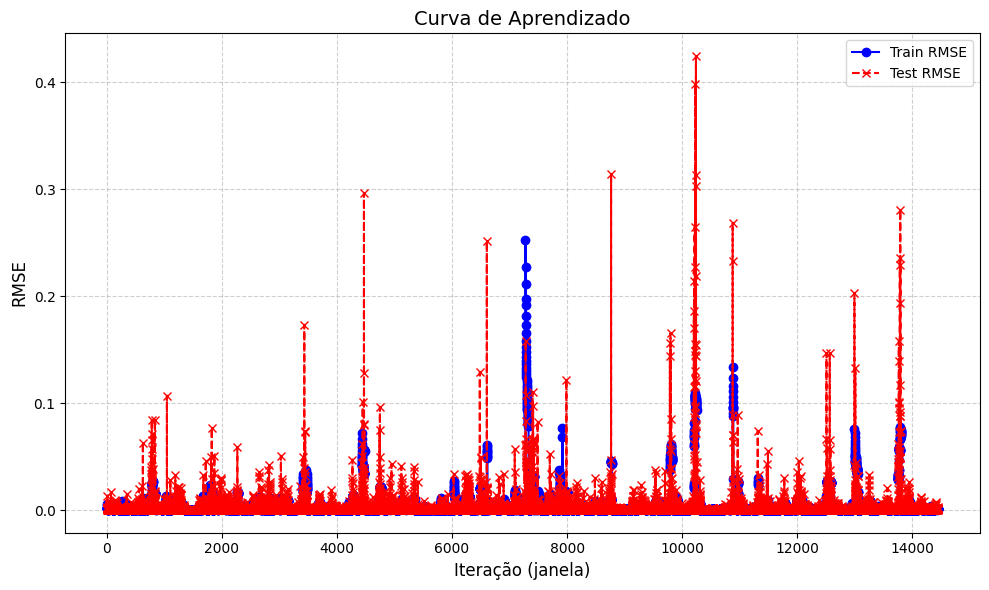

In [29]:
x_vals = range(len(resultado))  # ou resultado['Data'] se quiser por data

plt.figure(figsize=(10, 6))
plt.plot(x_vals, resultado['Train RMSE'], label='Train RMSE', marker='o', linestyle='-', color='blue')
plt.plot(x_vals, resultado['Test RMSE'], label='Test RMSE', marker='x', linestyle='--', color='red')
plt.title('Curva de Aprendizado', fontsize=14)
plt.xlabel('Iteração (janela)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

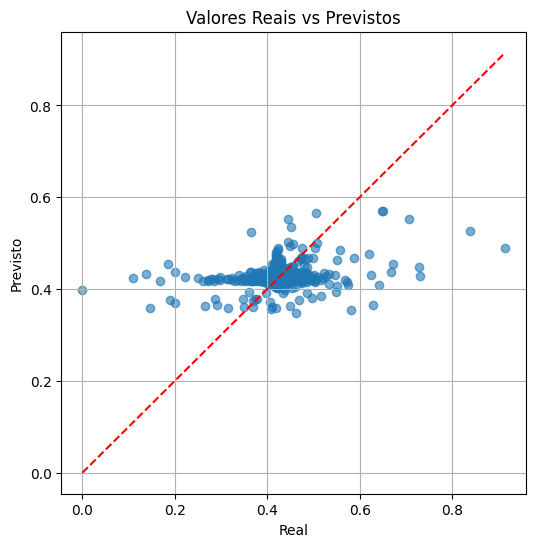

In [30]:
plt.figure(figsize=(6, 6))
plt.scatter(resultado['Real'], resultado['Previsto'], alpha=0.6)
plt.plot([resultado['Real'].min(), resultado['Real'].max()],
         [resultado['Real'].min(), resultado['Real'].max()],
         color='red', linestyle='--')
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Valores Reais vs Previstos')
plt.grid(True)
plt.show()

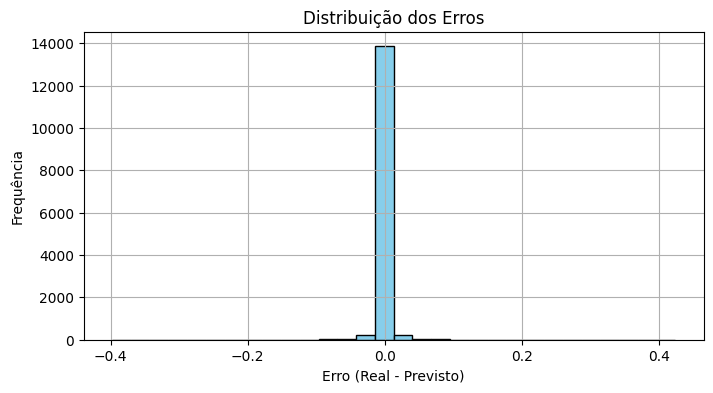

In [31]:
resultado['Erro'] = resultado['Real'] - resultado['Previsto']

plt.figure(figsize=(8, 4))
plt.hist(resultado['Erro'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Erros')
plt.xlabel('Erro (Real - Previsto)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

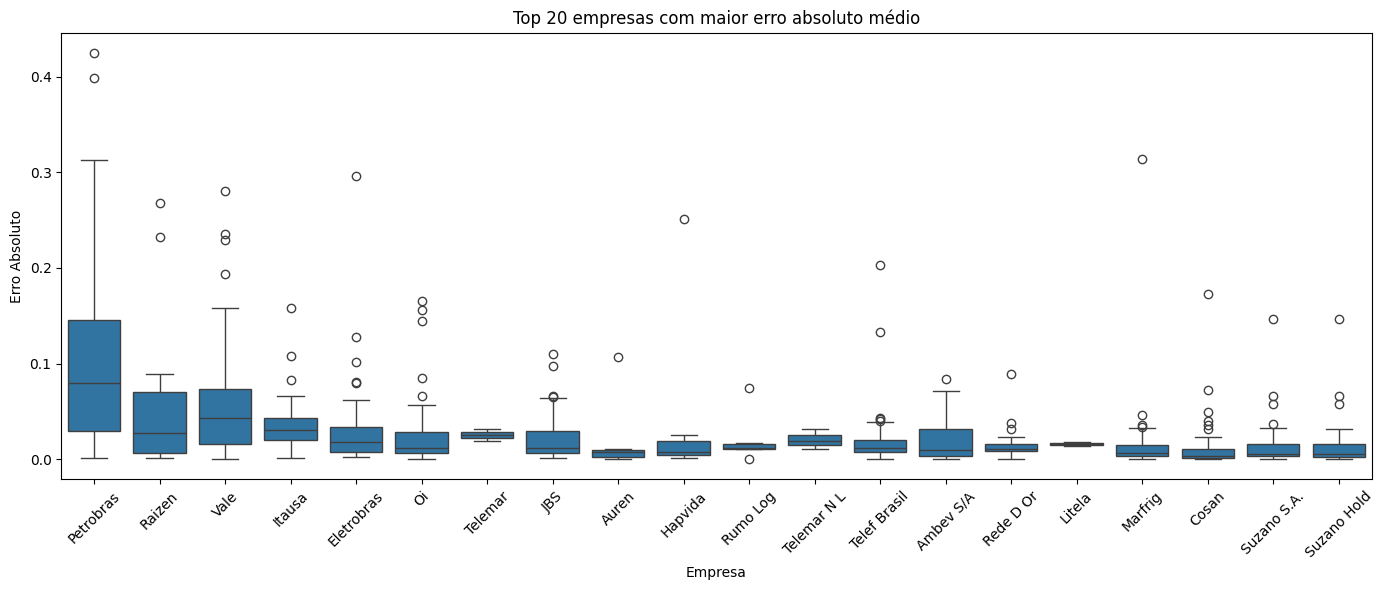

In [32]:
import seaborn as sns
top_n = 20
top_empresas = resultado.groupby('Empresa')['Erro Absoluto'].mean().nlargest(top_n).index

plt.figure(figsize=(14, 6))
sns.boxplot(data=resultado[resultado['Empresa'].isin(top_empresas)],
            x='Empresa', y='Erro Absoluto', order=top_empresas)
plt.xticks(rotation=45)
plt.title(f'Top {top_n} empresas com maior erro absoluto médio')
plt.tight_layout()
plt.show()

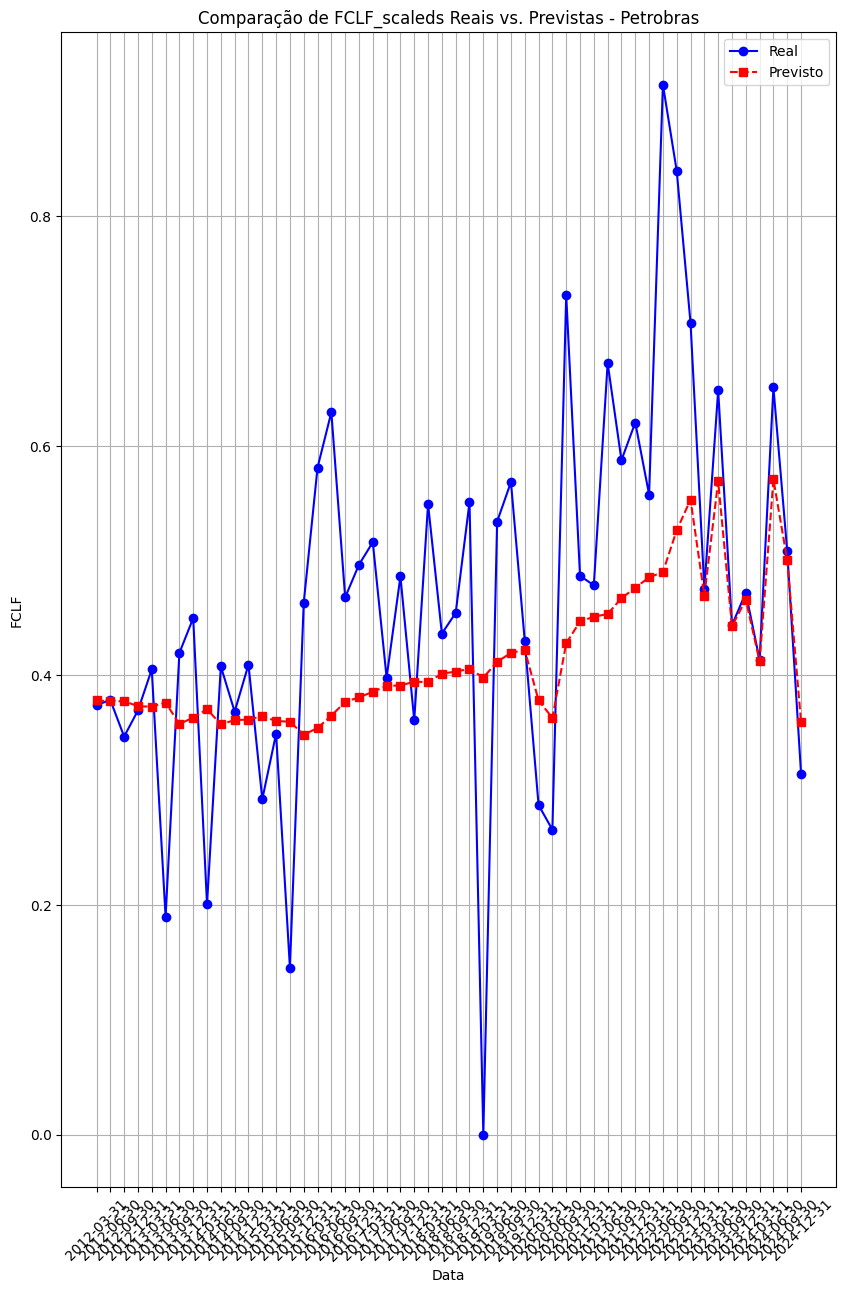

In [33]:
results_df = resultado
empresa_selecionada = 'Petrobras'
df_selecionado = results_df[results_df["Empresa"] == empresa_selecionada]

plt.figure(figsize=(10,15))
plt.plot(df_selecionado["Data"], df_selecionado["Real"], label="Real", marker='o', linestyle='solid', color="blue")
plt.plot(df_selecionado["Data"], df_selecionado["Previsto"], label="Previsto", marker='s', linestyle='dashed', color="red")

plt.xlabel("Data")
plt.ylabel("FCLF")
plt.title(f"Comparação de FCLF_scaleds Reais vs. Previstas - {empresa_selecionada}")
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização
plt.grid(True)

plt.show()